# Kütüphanelerin Yüklenmesi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
warnings.filterwarnings('ignore')

# Veri Yükleme

In [4]:
df = pd.read_excel("data/Dry_Bean_Dataset.xlsx")

# Eksik Veri Ekleme

In [6]:
for col in ['Area', 'Perimeter']:
    df.loc[df.sample(frac=0.05, random_state=42).index, col] = np.nan
df.loc[df.sample(frac=0.35, random_state=42).index, 'MajorAxisLength'] = np.nan

# Eksik Verilerin Doldurulması ve Silinmesi

In [8]:
df['Area'] = df['Area'].fillna(df['Area'].mean())
df['Perimeter'] = df['Perimeter'].fillna(df['Perimeter'].mean())
df = df.dropna(subset=['MajorAxisLength'])

# Aykırı Değerlerin Temizlenmesi (IQR Yöntemi)

In [10]:
Q1 = df['Area'].quantile(0.25)
Q3 = df['Area'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df['Area'] >= lower) & (df['Area'] <= upper)]

# Özellik Ölçekleme ve Label Encoding

In [12]:
X = df.drop(columns=["Class"])
y = df["Class"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(y)

# PCA Uygulaması ve Scatter Plot

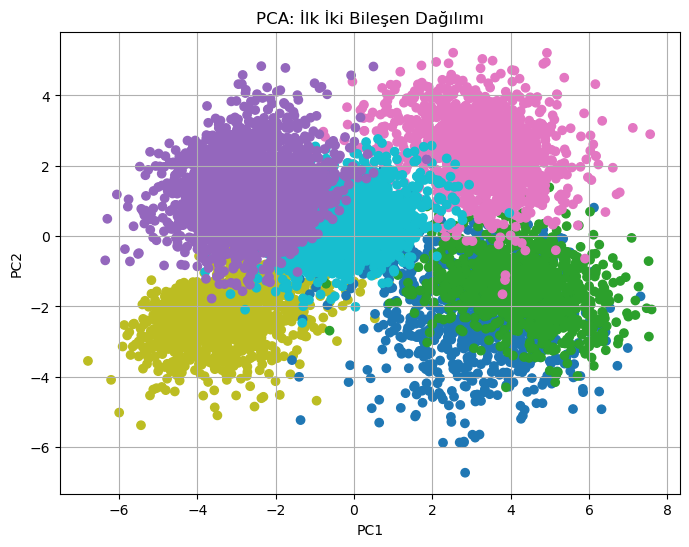

In [14]:
pca = PCA()
X_pca = pca.fit_transform(X)
threshold = pca.explained_variance_ratio_.mean()
num_components = sum(pca.explained_variance_ratio_ > threshold)
pca_final = pd.DataFrame(X_pca[:, :num_components], columns=[f'PC{i+1}' for i in range(num_components)])
pca_final['Class'] = y

# PCA Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_final["PC1"], pca_final["PC2"], c=y, cmap='tab10')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: İlk İki Bileşen Dağılımı")
plt.grid(True)
plt.savefig("results/pca_plot.png")
plt.show()

# LDA Uygulaması ve Scatter Plot

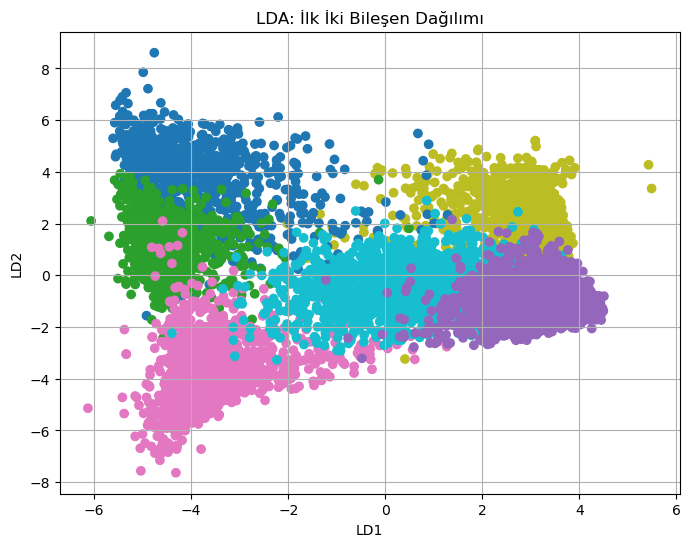

In [16]:
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X, y)
lda_final = pd.DataFrame(X_lda, columns=[f'LD{i+1}' for i in range(X_lda.shape[1])])
lda_final['Class'] = y

# LDA Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(lda_final["LD1"], lda_final["LD2"], c=y, cmap='tab10')
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA: İlk İki Bileşen Dağılımı")
plt.grid(True)
plt.savefig("results/lda_plot.png")
plt.show()

# Nested Cross-Validation ile Modelleme

In [18]:
def nested_cv(X, y, model, param_grid, outer_splits=5, inner_splits=3):
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
    
    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if param_grid:
            clf = GridSearchCV(model, param_grid, cv=inner_cv, scoring='accuracy')
        else:
            clf = model

        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_ if isinstance(clf, GridSearchCV) else clf
        y_pred = best_model.predict(X_test)

        scores['accuracy'].append(accuracy_score(y_test, y_pred))
        scores['precision'].append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        scores['recall'].append(recall_score(y_test, y_pred, average='weighted'))
        scores['f1'].append(f1_score(y_test, y_pred, average='weighted'))

        if hasattr(best_model, "predict_proba"):
            y_proba = best_model.predict_proba(X_test)
            scores['roc_auc'].append(roc_auc_score(y_test, y_proba, multi_class='ovr'))

    return {k: (np.mean(v), np.std(v)) for k, v in scores.items()}

models = {
    "Logistic Regression": (LogisticRegression(max_iter=5000), {'C': [1]}),
    "Decision Tree": (DecisionTreeClassifier(), {'max_depth': [5]}),
    "Random Forest": (RandomForestClassifier(), {'n_estimators': [100]}),
    "XGBoost": (XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), {'n_estimators': [50]}),
    "Naive Bayes": (GaussianNB(), {})
}

all_results = {}

for model_name, (model, param_grid) in models.items():
    print(f"Model: {model_name} işleniyor...")
    results = nested_cv(X, y, model, param_grid)
    all_results[model_name] = results

Model: Logistic Regression işleniyor...
Model: Decision Tree işleniyor...
Model: Random Forest işleniyor...
Model: XGBoost işleniyor...
Model: Naive Bayes işleniyor...


# Performans Sonuçlarını DataFrame'e çevirip CSV'ye kaydet

In [20]:
performance_data = []
for model_name, metrics in all_results.items():
    performance_data.append({
        "Model": model_name,
        "Mean Accuracy": metrics['accuracy'][0],
        "Std Accuracy": metrics['accuracy'][1],
        "Mean Precision": metrics['precision'][0],
        "Std Precision": metrics['precision'][1],
        "Mean Recall": metrics['recall'][0],
        "Std Recall": metrics['recall'][1],
        "Mean F1": metrics['f1'][0],
        "Std F1": metrics['f1'][1],
        "Mean ROC-AUC": metrics['roc_auc'][0] if 'roc_auc' in metrics else np.nan,
        "Std ROC-AUC": metrics['roc_auc'][1] if 'roc_auc' in metrics else np.nan,
    })

performance_table = pd.DataFrame(performance_data)
performance_table.to_csv("results/performance_table.csv", index=False)
performance_table

,Model,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall,Mean F1,Std F1,Mean ROC-AUC,Std ROC-AUC
0,Logistic Regression,0.920649,0.005103,0.921135,0.005304,0.920649,0.005103,0.920631,0.005264,0.993400,0.000353
1,Decision Tree,0.889804,0.006976,0.892691,0.007511,0.889804,0.006976,0.889629,0.007504,0.978026,0.002585
2,Random Forest,0.916647,0.005865,0.916840,0.005994,0.916647,0.005865,0.916474,0.006063,0.991679,0.000551
3,XGBoost,0.922179,0.009192,0.922591,0.009093,0.922179,0.009192,0.922160,0.009167,0.993775,0.000285
4,Naive Bayes,0.892394,0.002064,0.893761,0.001703,0.892394,0.002064,0.892490,0.001964,0.989190,0.000229


# ROC Curve Çizimi (OVA Yöntemiyle)

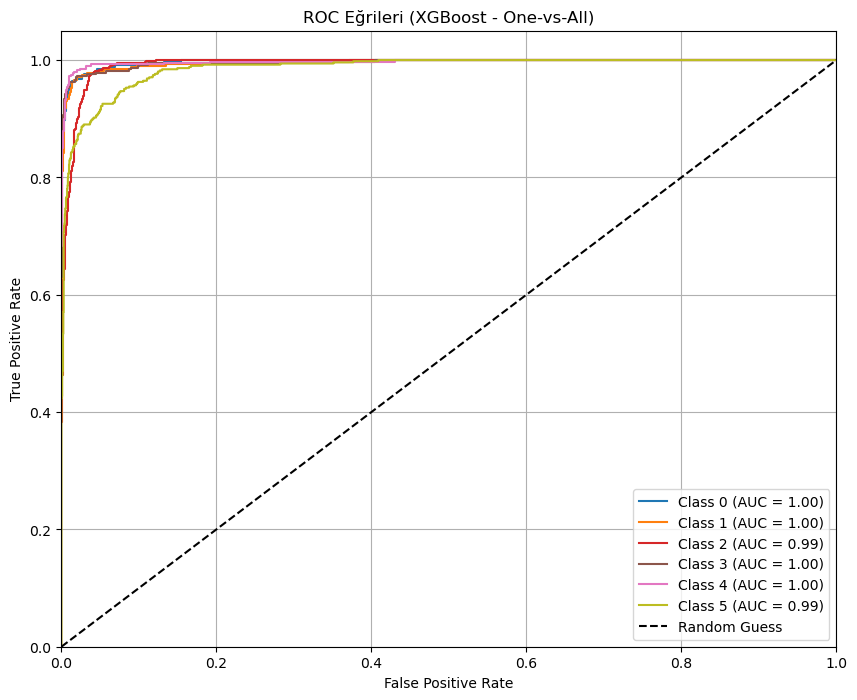

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)
n_classes = len(np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = plt.colormaps.get_cmap('tab10')

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})", color=colors(i / n_classes))

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrileri (XGBoost - One-vs-All)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("results/roc_curve.png")
plt.show()